In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/SPAM text message 20170820 - Data.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.isna().sum()

,0
Category,0
Message,0


In [4]:
df.shape

(5572, 2)

In [5]:
import re
import spacy
nlp = spacy.load('en_core_web_sm')

def clean_text(text):
# RE

    text = text.lower()
    # Remove URLs and links (http, https, www)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove email
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', text)

    # Remove anything that is not a character (retain letters and spaces only)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra spaces (collapse multiple spaces into a single space)
    text = re.sub(r'\s+', ' ', text)

    # Remove leading/trailing spaces
    text = text.strip()

# NLP

    doc = nlp(text)

    cleaned_txt = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    text = ' '.join(cleaned_txt)

    return text

df['cleaned_message'] = df['Message'].apply(clean_text)
df.head()

,Category,Message,cleaned_message
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah not think go usf live


In [18]:
X = df['cleaned_message']
y = df['Category']

In [19]:
processed_y = y.map({'spam':0,"ham":1})
processed_y.head()

,Category
0,1
1,1
2,0
3,1
4,1


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, processed_y, test_size=0.2, random_state=42, stratify=processed_y)

#Machine learning

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfIdf = TfidfVectorizer()
X_train = tfIdf.fit_transform(X_train)
X_test = tfIdf.transform(X_test)

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

estimators = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(),
    'SVC': SVC(),
    'LinearSVC': LinearSVC(),
    'RandomForestClassifier': RandomForestClassifier()
}

params = {
    'MultinomialNB': {},
    'LogisticRegression': {'C': [0.01,0.1,1,10]},
    'SVC': {'C': [0.01,0.1,1,10]},
    'LinearSVC': {'C': [0.01,0.1,1,10]},
    'RandomForestClassifier': {'n_estimators': [0.01,0.1,1,10]},
}

best_estimator = {}
for name,model in estimators.items():
    model = GridSearchCV(estimator=model, param_grid=params[name], cv=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(name)
    print(accuracy_score(y_test, y_pred))
    best_estimator[name] = model.best_estimator_

MultinomialNB
0.9596412556053812
LogisticRegression
0.9721973094170404
SVC
0.9730941704035875
LinearSVC
0.9748878923766816
RandomForestClassifier
0.9668161434977578


In [14]:
best_model = best_estimator['LinearSVC']
y_pred = best_model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9748878923766816
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       149
           1       0.98      0.99      0.99       966

    accuracy                           0.97      1115
   macro avg       0.96      0.93      0.94      1115
weighted avg       0.97      0.97      0.97      1115



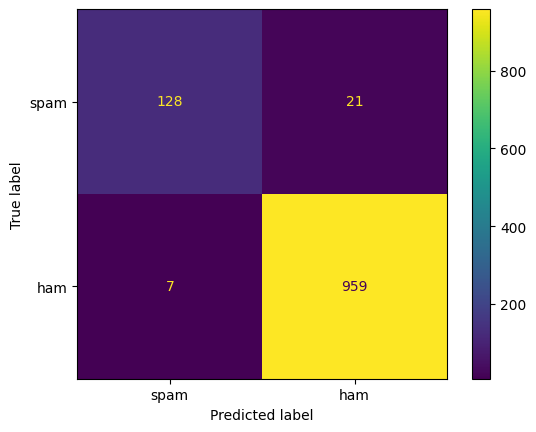

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['spam', 'ham'])
disp.plot()
plt.show()

#LSTM

In [32]:
num_words = set()
for i in X_train:
  for word in i.split():
    num_words.add(word)

print(len(num_words))

6371


In [33]:
import tensorflow as to
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

num_words = 6000
tokenizer = Tokenizer(num_words=num_words,oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [34]:
maxlen = max(len(text.split()) for text in X_train)
train_sequences = pad_sequences(train_sequences, maxlen=maxlen)
test_sequences = pad_sequences(test_sequences, maxlen=maxlen)

In [35]:
model = Sequential([
    Embedding(input_dim=num_words, output_dim=128, input_length=maxlen),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

model.fit(train_sequences, y_train, epochs=10, batch_size=32, validation_data=(test_sequences, y_test), callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 46s 253ms/step - accuracy: 0.8933 - loss: 0.2934 - val_accuracy: 0.9740 - val_loss: 0.0899 - learning_rate: 0.0010
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 34s 203ms/step - accuracy: 0.9876 - loss: 0.0466 - val_accuracy: 0.9794 - val_loss: 0.0821 - learning_rate: 0.0010
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 30s 215ms/step - accuracy: 0.9949 - loss: 0.0167 - val_accuracy: 0.9767 - val_loss: 0.0831 - learning_rate: 0.0010
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 40s 209ms/step - accuracy: 0.9975 - loss: 0.0112 - val_accuracy: 0.9776 - val_loss: 0.1151 - learning_rate: 0.0010
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 40s 201ms/step - accuracy: 0.9998 - loss: 0.0021 - val_accuracy: 0.9776 - val_loss: 0.1260 - learning_rate: 0.0010


In [38]:
best_model = to.keras.models.load_model('best_model.keras')
y_pred = best_model.predict(test_sequences)
y_pred = (y_pred > 0.5).astype(int)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step
0.979372197309417
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       149
           1       0.98      0.99      0.99       966

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115



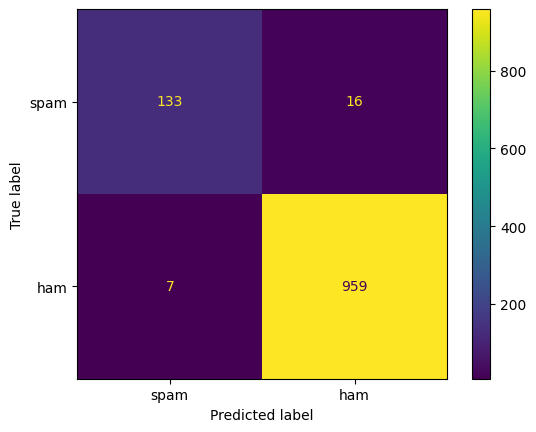

In [39]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['spam', 'ham'])
disp.plot()
plt.show()